In [50]:
# Imports
import mne
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from pathlib import Path
import os
import warnings
warnings.filterwarnings('ignore')

torch.manual_seed(42)
np.random.seed(42)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using: {device}")

Using: cuda


In [62]:
# ========================================
# ANTI-OVERFITTING GAN SYSTEM
# ========================================

class EEGGANTrainer:
    """
    GAN trainer with anti-overfitting controls for small datasets
    
    Usage:
        trainer = EEGGANTrainer(data, name='my_experiment', gan_type='vanilla')
        trainer.train(epochs=100)  # Fewer epochs to prevent memorization
        synthetic = trainer.generate(n_samples=100)
    """
    
    def __init__(self, data, name='experiment', device='cpu', gan_type='vanilla'):
        """
        Initialize GAN trainer
        
        Parameters:
        -----------
        data : numpy array
            EEG data with shape (n_samples, n_channels, n_timepoints)
        name : str
            Name for this experiment
        device : str
            'cpu' or 'cuda'
        gan_type : str
            'vanilla' or 'wgan-gp'
        """
        self.data = data
        self.name = name
        self.device = device
        self.gan_type = gan_type
        
        self.n_samples = data.shape[0]
        self.n_channels = data.shape[1]
        self.n_timepoints = data.shape[2]
        
        print(f"Initialized EEGGANTrainer ({gan_type}): {name}")
        print(f"  Data: {data.shape}")
        print(f"  Device: {device}")
        
        # ANTI-OVERFITTING: Warn if dataset is small
        if self.n_samples < 500:
            print(f"  ⚠️ WARNING: Small dataset ({self.n_samples} samples)")
            print(f"     → Risk of overfitting/memorization")
            print(f"     → Using smaller model + early stopping")
        
        self._create_models()
        self._create_dataset()
        
        self.history = {'G_losses': [], 'D_losses': [], 'metrics': []}
        self.best_metric = float('inf')
        self.best_epoch = 0
    
    def _create_models(self):
        """Create SMALLER models to prevent overfitting on small datasets"""
        data_size = self.n_channels * self.n_timepoints
        
        # ANTI-OVERFITTING: Smaller model (512→256 instead of 2048→1024)
        # Fewer parameters = less memorization capacity
        self.G = nn.Sequential(
            nn.Linear(data_size, 512),  # REDUCED from 2048
            nn.LayerNorm(512),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.5),  # INCREASED from 0.3
            
            nn.Linear(512, 256),  # REDUCED from 1024
            nn.LayerNorm(256),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.5),  # INCREASED from 0.3
            
            nn.Linear(256, data_size)
        ).to(self.device)
        
        # ANTI-OVERFITTING: Smaller discriminator
        layers = [
            nn.Linear(data_size, 256),  # REDUCED from 512
            nn.LayerNorm(256),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.5),  # INCREASED from 0.3
            
            nn.Linear(256, 128),  # REDUCED from 256
            nn.LeakyReLU(0.2),
            nn.Dropout(0.5),  # INCREASED from 0.3
            
            nn.Linear(128, 1)
        ]
        
        if self.gan_type == 'vanilla':
            layers.append(nn.Sigmoid())
        
        self.D = nn.Sequential(*layers).to(self.device)
        
        print(f"✓ ANTI-OVERFITTING models created")
        print(f"  Generator: {sum(p.numel() for p in self.G.parameters()):,} params (REDUCED)")
        print(f"  {'Critic' if self.gan_type == 'wgan-gp' else 'Discriminator'}: {sum(p.numel() for p in self.D.parameters()):,} params (REDUCED)")
    
    def _create_dataset(self):
        """Create PyTorch dataset"""
        class EEGDataset(Dataset):
            def __init__(self, data):
                self.data = torch.FloatTensor(data)
            def __len__(self):
                return len(self.data)
            def __getitem__(self, idx):
                return self.data[idx]
        
        dataset = EEGDataset(self.data)
        self.dataloader = DataLoader(dataset, batch_size=32, shuffle=True)
        print(f"✓ Dataset: {len(dataset)} samples, {len(self.dataloader)} batches")
    
    def _compute_gradient_penalty(self, real, fake):
        """Gradient penalty for WGAN-GP"""
        batch_size = real.size(0)
        alpha = torch.rand(batch_size, 1, device=self.device)
        
        real_flat = real.reshape(batch_size, -1)
        fake_flat = fake.reshape(batch_size, -1)
        
        interpolates = (alpha * real_flat + (1 - alpha) * fake_flat).requires_grad_(True)
        d_interpolates = self.D(interpolates)
        
        gradients = torch.autograd.grad(
            outputs=d_interpolates,
            inputs=interpolates,
            grad_outputs=torch.ones_like(d_interpolates),
            create_graph=True,
            retain_graph=True
        )[0]
        
        gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean()
        return gradient_penalty
    
    def train(self, epochs=100, lr=0.0002, save_best=True):  # DEFAULT: 100 epochs (not 300!)
        """Train GAN with anti-overfitting controls"""
        if self.gan_type == 'vanilla':
            self._train_vanilla(epochs, lr, save_best)
        else:
            self._train_wgan_gp(epochs, lr, save_best)
    
    def _train_vanilla(self, epochs, lr, save_best):
        """Vanilla GAN with EARLY STOPPING and noise injection"""
        criterion = nn.BCELoss()
        G_opt = optim.Adam(self.G.parameters(), lr=lr, betas=(0.5, 0.999))
        D_opt = optim.Adam(self.D.parameters(), lr=lr, betas=(0.5, 0.999))
        
        # ANTI-OVERFITTING: Early stopping patience
        patience = 20
        no_improve_count = 0
        
        print(f"\nTraining Vanilla GAN with ANTI-OVERFITTING controls...")
        print(f"  Max epochs: {epochs}")
        print(f"  Early stopping patience: {patience}")
        print("="*60)
        
        for epoch in range(epochs):
            G_losses, D_losses = [], []
            
            for real_eeg in self.dataloader:
                real_eeg = real_eeg.to(self.device)
                batch_size = real_eeg.shape[0]
                
                # ANTI-OVERFITTING: Add small noise to real data
                real_eeg = real_eeg + torch.randn_like(real_eeg) * 0.01
                
                # Train Discriminator
                D_opt.zero_grad()
                real_pred = self.D(real_eeg.reshape(batch_size, -1))
                real_labels = torch.ones(batch_size, 1, device=self.device) * 0.9
                loss_real = criterion(real_pred, real_labels)
                
                noise = torch.randn_like(real_eeg, device=self.device)
                fake_eeg = self.G(noise.reshape(batch_size, -1))
                fake_pred = self.D(fake_eeg.detach())
                fake_labels = torch.zeros(batch_size, 1, device=self.device)
                loss_fake = criterion(fake_pred, fake_labels)
                
                D_loss = (loss_real + loss_fake) / 2
                D_loss.backward()
                torch.nn.utils.clip_grad_norm_(self.D.parameters(), 1.0)
                D_opt.step()
                
                # Train Generator
                G_opt.zero_grad()
                noise = torch.randn_like(real_eeg, device=self.device)
                fake_eeg = self.G(noise.reshape(batch_size, -1))
                fake_pred = self.D(fake_eeg)
                
                # ANTI-OVERFITTING: Add diversity penalty
                # Encourage different outputs from different noise
                noise2 = torch.randn_like(real_eeg, device=self.device)
                fake_eeg2 = self.G(noise2.reshape(batch_size, -1))
                diversity_loss = -torch.mean((fake_eeg - fake_eeg2) ** 2)
                
                G_loss = criterion(fake_pred, torch.ones(batch_size, 1, device=self.device))
                G_loss = G_loss + 0.1 * diversity_loss  # Add diversity term
                
                G_loss.backward()
                torch.nn.utils.clip_grad_norm_(self.G.parameters(), 1.0)
                G_opt.step()
                
                G_losses.append(G_loss.item())
                D_losses.append(D_loss.item())
            
            self.history['G_losses'].append(np.mean(G_losses))
            self.history['D_losses'].append(np.mean(D_losses))
            
            if (epoch + 1) % 10 == 0:  # Check more frequently (every 10 epochs)
                metric = self._evaluate()
                self.history['metrics'].append(metric)
                
                # ANTI-OVERFITTING: Early stopping
                if save_best and metric < self.best_metric:
                    self.best_metric = metric
                    self.best_epoch = epoch + 1
                    self.save_model()
                    no_improve_count = 0
                    status = "✓ NEW BEST"
                else:
                    no_improve_count += 1
                    status = f"(no improve: {no_improve_count}/{patience})"
                
                print(f"Epoch {epoch+1:3d}/{epochs} | D: {self.history['D_losses'][-1]:.4f} | "
                      f"G: {self.history['G_losses'][-1]:.4f} | Metric: {metric:.4f} | {status}")
                
                # ANTI-OVERFITTING: Stop if no improvement
                if no_improve_count >= patience:
                    print(f"\n⚠️ EARLY STOPPING at epoch {epoch+1}")
                    print(f"   No improvement for {patience} checks")
                    print(f"   Best was: {self.best_metric:.4f} at epoch {self.best_epoch}")
                    break
        
        print("="*60)
        print(f"✓ Training complete! Best: {self.best_metric:.4f} @ epoch {self.best_epoch}")
        if save_best:
            self.load_best_model()
    
    def _train_wgan_gp(self, epochs, lr, save_best, lambda_gp=10, n_critic=3):  # REDUCED n_critic from 5
        """WGAN-GP with anti-overfitting controls"""
        G_opt = optim.RMSprop(self.G.parameters(), lr=lr * 0.5)
        D_opt = optim.RMSprop(self.D.parameters(), lr=lr)
        
        patience = 20
        no_improve_count = 0
        
        print(f"\nTraining WGAN-GP with ANTI-OVERFITTING controls...")
        print(f"  Max epochs: {epochs}")
        print(f"  Early stopping patience: {patience}")
        print(f"  Critic iterations: {n_critic} (reduced from 5)")
        print("="*60)
        
        for epoch in range(epochs):
            G_losses, D_losses = [], []
            
            for real_eeg in self.dataloader:
                real_eeg = real_eeg.to(self.device)
                batch_size = real_eeg.shape[0]
                
                # ANTI-OVERFITTING: Add noise to real data
                real_eeg = real_eeg + torch.randn_like(real_eeg) * 0.01
                
                # Train Critic (fewer times to prevent overfitting)
                for _ in range(n_critic):
                    D_opt.zero_grad()
                    
                    real_score = self.D(real_eeg.reshape(batch_size, -1))
                    
                    noise = torch.randn_like(real_eeg, device=self.device)
                    fake_eeg = self.G(noise.reshape(batch_size, -1))
                    fake_score = self.D(fake_eeg.detach())
                    
                    gp = self._compute_gradient_penalty(
                        real_eeg, 
                        fake_eeg.reshape(batch_size, self.n_channels, self.n_timepoints)
                    )
                    
                    D_loss = fake_score.mean() - real_score.mean() + lambda_gp * gp
                    
                    D_loss.backward()
                    D_opt.step()
                    D_losses.append(D_loss.item())
                
                # Train Generator
                G_opt.zero_grad()
                noise = torch.randn_like(real_eeg, device=self.device)
                fake_eeg = self.G(noise.reshape(batch_size, -1))
                fake_score = self.D(fake_eeg)
                
                # ANTI-OVERFITTING: Diversity penalty
                noise2 = torch.randn_like(real_eeg, device=self.device)
                fake_eeg2 = self.G(noise2.reshape(batch_size, -1))
                diversity_loss = -torch.mean((fake_eeg - fake_eeg2) ** 2)
                
                G_loss = -fake_score.mean() + 0.1 * diversity_loss
                
                G_loss.backward()
                G_opt.step()
                G_losses.append(G_loss.item())
            
            self.history['G_losses'].append(np.mean(G_losses))
            self.history['D_losses'].append(np.mean(D_losses))
            
            if (epoch + 1) % 10 == 0:
                metric = self._evaluate()
                self.history['metrics'].append(metric)
                
                if save_best and metric < self.best_metric:
                    self.best_metric = metric
                    self.best_epoch = epoch + 1
                    self.save_model()
                    no_improve_count = 0
                    status = "✓ NEW BEST"
                else:
                    no_improve_count += 1
                    status = f"(no improve: {no_improve_count}/{patience})"
                
                print(f"Epoch {epoch+1:3d}/{epochs} | C: {self.history['D_losses'][-1]:.4f} | "
                      f"G: {self.history['G_losses'][-1]:.4f} | Metric: {metric:.4f} | {status}")
                
                if no_improve_count >= patience:
                    print(f"\n⚠️ EARLY STOPPING at epoch {epoch+1}")
                    print(f"   No improvement for {patience} checks")
                    break
        
        print("="*60)
        print(f"✓ Training complete! Best: {self.best_metric:.4f} @ epoch {self.best_epoch}")
        if save_best:
            self.load_best_model()
    
    def _evaluate(self):
        """Evaluate model quality"""
        with torch.no_grad():
            noise = torch.randn(100, self.n_channels, self.n_timepoints, device=self.device)
            fake = self.G(noise.reshape(100, -1))
            fake_reshaped = fake.reshape(100, self.n_channels, self.n_timepoints)
            fake_std = fake_reshaped.cpu().numpy().std()
            real_std = self.data.std()
            return abs(fake_std - real_std)
    
    def generate(self, n_samples=100):
        """Generate synthetic samples"""
        self.G.eval()
        samples = []
        
        with torch.no_grad():
            for i in range(n_samples):
                noise = torch.randn(1, self.n_channels, self.n_timepoints, device=self.device)
                fake = self.G(noise.reshape(1, -1))
                fake_reshaped = fake.reshape(self.n_channels, self.n_timepoints)
                samples.append(fake_reshaped.cpu().numpy())
        
        return np.array(samples)
    
    def save_model(self):
        """Save model"""
        os.makedirs('../../models', exist_ok=True)
        path = f'../../models/gan_{self.name}_{self.gan_type}.pt'
        torch.save({
            'G': self.G.state_dict(), 
            'D': self.D.state_dict(),
            'history': self.history
        }, path)
    
    def load_best_model(self):
        """Load best model"""
        path = f'../../models/gan_{self.name}_{self.gan_type}.pt'
        checkpoint = torch.load(path)
        self.G.load_state_dict(checkpoint['G'])
        self.D.load_state_dict(checkpoint['D'])
        print(f"✓ Loaded best model from {path}")
    
    def evaluate(self, synthetic_data):
        """Comprehensive evaluation"""
        mean_error = abs(self.data.mean() - synthetic_data.mean())
        std_error = abs(self.data.std() - synthetic_data.std())
        
        n_eval = min(1000, len(self.data), len(synthetic_data))
        mmd = self._compute_mmd(self.data[:n_eval], synthetic_data[:n_eval])
        
        stat_score = max(0, 100 - (mean_error * 1000 + std_error * 100))
        mmd_score = max(0, 100 - (mmd * 1000))
        overall = (stat_score + mmd_score) / 2
        
        return {
            'mean_error': mean_error,
            'std_error': std_error,
            'mmd_rbf': mmd,
            'stat_score': stat_score,
            'mmd_score': mmd_score,
            'overall_score': overall,
            'quality': self._get_quality_label(overall)
        }
    
    def _compute_mmd(self, real_data, fake_data):
        """Compute MMD"""
        real_flat = torch.FloatTensor(real_data.reshape(real_data.shape[0], -1))
        fake_flat = torch.FloatTensor(fake_data.reshape(fake_data.shape[0], -1))
        
        def gaussian_kernel(x, y):
            x_norm = (x ** 2).sum(1).view(-1, 1)
            y_norm = (y ** 2).sum(1).view(1, -1)
            dist = x_norm + y_norm - 2.0 * torch.mm(x, y.t())
            gamma = 1.0 / (2 * torch.median(dist[dist > 0]))
            return torch.exp(-gamma * dist)
        
        K_rr = gaussian_kernel(real_flat, real_flat)
        K_ff = gaussian_kernel(fake_flat, fake_flat)
        K_rf = gaussian_kernel(real_flat, fake_flat)
        
        n_r, n_f = len(real_flat), len(fake_flat)
        mmd_sq = (K_rr.sum() / (n_r * (n_r - 1)) +
                  K_ff.sum() / (n_f * (n_f - 1)) -
                  2 * K_rf.sum() / (n_r * n_f))
        
        return torch.sqrt(torch.clamp(mmd_sq, min=0.0)).item()
    
    def _get_quality_label(self, score):
        """Quality label"""
        if score >= 80: return "Excellent ⭐⭐⭐⭐⭐"
        if score >= 60: return "Good ⭐⭐⭐⭐"
        if score >= 40: return "Fair ⭐⭐⭐"
        return "Needs Improvement ⭐⭐"
    
    def plot_comparison(self, synthetic_data, save_path=None):
        """Plot comparison"""
        fig, axes = plt.subplots(2, 2, figsize=(14, 8))
        
        axes[0, 0].plot(self.data[0].T, alpha=0.5, linewidth=0.5)
        axes[0, 0].set_title(f'Real {self.name}', fontweight='bold')
        axes[0, 0].set_ylim(-4, 4)
        
        axes[0, 1].plot(synthetic_data[0].T, alpha=0.5, linewidth=0.5)
        axes[0, 1].set_title(f'Generated {self.name} ({self.gan_type})', fontweight='bold')
        axes[0, 1].set_ylim(-4, 4)
        
        axes[1, 0].plot(self.data[0, 0], label='Real', alpha=0.7, linewidth=2)
        axes[1, 0].plot(synthetic_data[0, 0], label='Generated', alpha=0.7, linewidth=2)
        axes[1, 0].set_title('Single Channel', fontweight='bold')
        axes[1, 0].legend()
        
        axes[1, 1].hist(self.data.flatten(), bins=50, alpha=0.5, label='Real', density=True)
        axes[1, 1].hist(synthetic_data.flatten(), bins=50, alpha=0.5, label='Generated', density=True)
        axes[1, 1].set_title('Distribution', fontweight='bold')
        axes[1, 1].legend()
        
        plt.tight_layout()
        if save_path:
            plt.savefig(save_path, dpi=150)
        plt.show()
    
    def save_results(self, synthetic_data, evaluation):
        """Save results"""
        os.makedirs('../../synthetic_data', exist_ok=True)
        np.save(f'../../synthetic_data/synthetic_{self.name}_{self.gan_type}.npy', synthetic_data)
        np.save(f'../../synthetic_data/evaluation_{self.name}_{self.gan_type}.npy', evaluation)
        print(f"✓ Saved results for {self.name} ({self.gan_type})")

print("✓ ANTI-OVERFITTING EEGGANTrainer loaded")
print("Changes:")
print("  • Smaller models (512→256 vs 2048→1024)")
print("  • Higher dropout (0.5 vs 0.3)")
print("  • Default 100 epochs (vs 300)")
print("  • Early stopping (patience=20)")
print("  • Noise injection on real data")
print("  • Diversity penalty in loss")
print("  • Reduced WGAN-GP critic iterations (3 vs 5)")

✓ ANTI-OVERFITTING EEGGANTrainer loaded
Changes:
  • Smaller models (512→256 vs 2048→1024)
  • Higher dropout (0.5 vs 0.3)
  • Default 100 epochs (vs 300)
  • Early stopping (patience=20)
  • Noise injection on real data
  • Diversity penalty in loss
  • Reduced WGAN-GP critic iterations (3 vs 5)


In [64]:
# Load individual segment files from eyes_closed_individual folder
import glob

# Path to individual segments
individual_dir_closed = os.path.join('..', '..', 'gan_data', 'eyes_closed_individual')
individual_dir_open = os.path.join('..', '..', 'gan_data', 'eyes_open_individual')

# Get all individual segment files
closed_files = sorted(glob.glob(os.path.join(individual_dir_closed, '*.npy')))
open_files = sorted(glob.glob(os.path.join(individual_dir_open, '*.npy')))

print(f"Found {len(closed_files)} eyes closed segments")
print(f"Found {len(open_files)} eyes open segments")

# Load all individual segments
segments_closed = np.array([np.load(f) for f in closed_files])
segments_open = np.array([np.load(f) for f in open_files])

print(f"\n✓ Loaded eyes closed: {segments_closed.shape}")
print(f"✓ Loaded eyes open: {segments_open.shape}")

Found 66 eyes closed segments
Found 74 eyes open segments

✓ Loaded eyes closed: (66, 129, 500)
✓ Loaded eyes open: (74, 129, 500)


✓ Using eyes open data: (74, 129, 500)
Initialized EEGGANTrainer (wgan-gp): eyes_open
  Data: (74, 129, 500)
  Device: cuda
  ⚠️ WARNING: Small dataset (74 samples)
     → Risk of overfitting/memorization
     → Using smaller model + early stopping
✓ ANTI-OVERFITTING models created
  Generator: 49,733,876 params (REDUCED)
  Critic: 16,545,793 params (REDUCED)
✓ Dataset: 74 samples, 3 batches

Training WGAN-GP with ANTI-OVERFITTING controls...
  Max epochs: 300
  Early stopping patience: 20
  Critic iterations: 3 (reduced from 5)
✓ ANTI-OVERFITTING models created
  Generator: 49,733,876 params (REDUCED)
  Critic: 16,545,793 params (REDUCED)
✓ Dataset: 74 samples, 3 batches

Training WGAN-GP with ANTI-OVERFITTING controls...
  Max epochs: 300
  Early stopping patience: 20
  Critic iterations: 3 (reduced from 5)
Epoch  10/300 | C: -6.6536 | G: -1.0612 | Metric: 0.4137 | ✓ NEW BEST
Epoch  10/300 | C: -6.6536 | G: -1.0612 | Metric: 0.4137 | ✓ NEW BEST
Epoch  20/300 | C: -28.6892 | G: 17.358

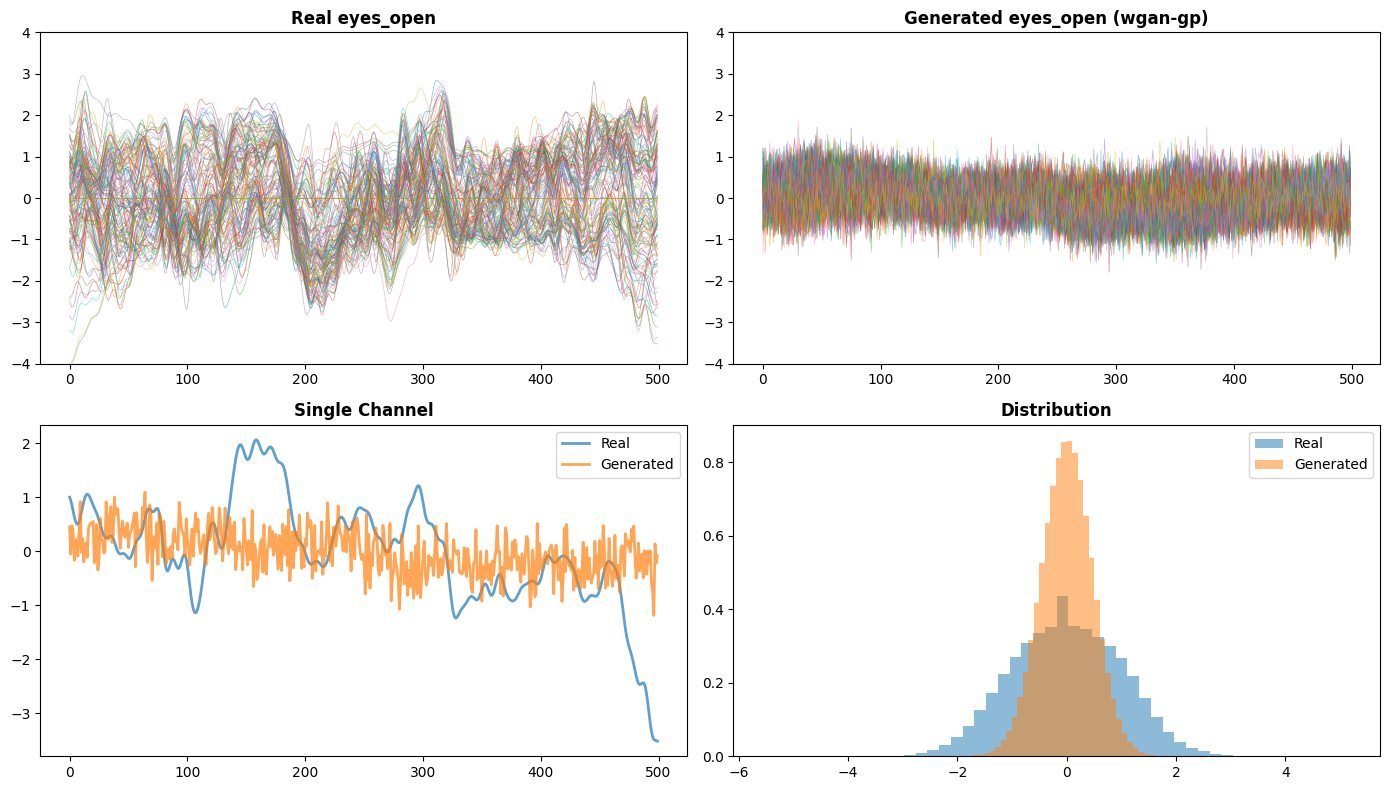

✓ Saved results for eyes_open (wgan-gp)


In [70]:
# Train eyes open GAN (data already loaded above)
print(f"✓ Using eyes open data: {segments_open.shape}")

# TRAIN IN 3 LINES!
trainer_open = EEGGANTrainer(segments_open, name='eyes_open', device=device, gan_type='wgan-gp')
trainer_open.train(epochs=300)
synthetic_open = trainer_open.generate(n_samples=100)

# Evaluate
eval_open = trainer_open.evaluate(synthetic_open)
print("\n" + "="*60)
print("EVALUATION RESULTS: EYES OPEN")
print("="*60)
for key, value in eval_open.items():
    print(f"  {key}: {value}")
print("="*60)

# Visualize
trainer_open.plot_comparison(synthetic_open, save_path='../../figures/eyes_open_gan.png')

# Save
trainer_open.save_results(synthetic_open, eval_open)

Initialized EEGGANTrainer (wgan-gp): eyes_closed
  Data: (66, 129, 500)
  Device: cuda
  ⚠️ WARNING: Small dataset (66 samples)
     → Risk of overfitting/memorization
     → Using smaller model + early stopping
✓ ANTI-OVERFITTING models created
  Generator: 49,733,876 params (REDUCED)
  Critic: 16,545,793 params (REDUCED)
✓ Dataset: 66 samples, 3 batches

Training WGAN-GP with ANTI-OVERFITTING controls...
  Max epochs: 300
  Early stopping patience: 20
  Critic iterations: 3 (reduced from 5)
✓ ANTI-OVERFITTING models created
  Generator: 49,733,876 params (REDUCED)
  Critic: 16,545,793 params (REDUCED)
✓ Dataset: 66 samples, 3 batches

Training WGAN-GP with ANTI-OVERFITTING controls...
  Max epochs: 300
  Early stopping patience: 20
  Critic iterations: 3 (reduced from 5)
Epoch  10/300 | C: -1.1590 | G: -2.3042 | Metric: 0.4152 | ✓ NEW BEST
Epoch  10/300 | C: -1.1590 | G: -2.3042 | Metric: 0.4152 | ✓ NEW BEST
Epoch  20/300 | C: -13.6495 | G: 4.3579 | Metric: 0.4101 | ✓ NEW BEST
Epoch 

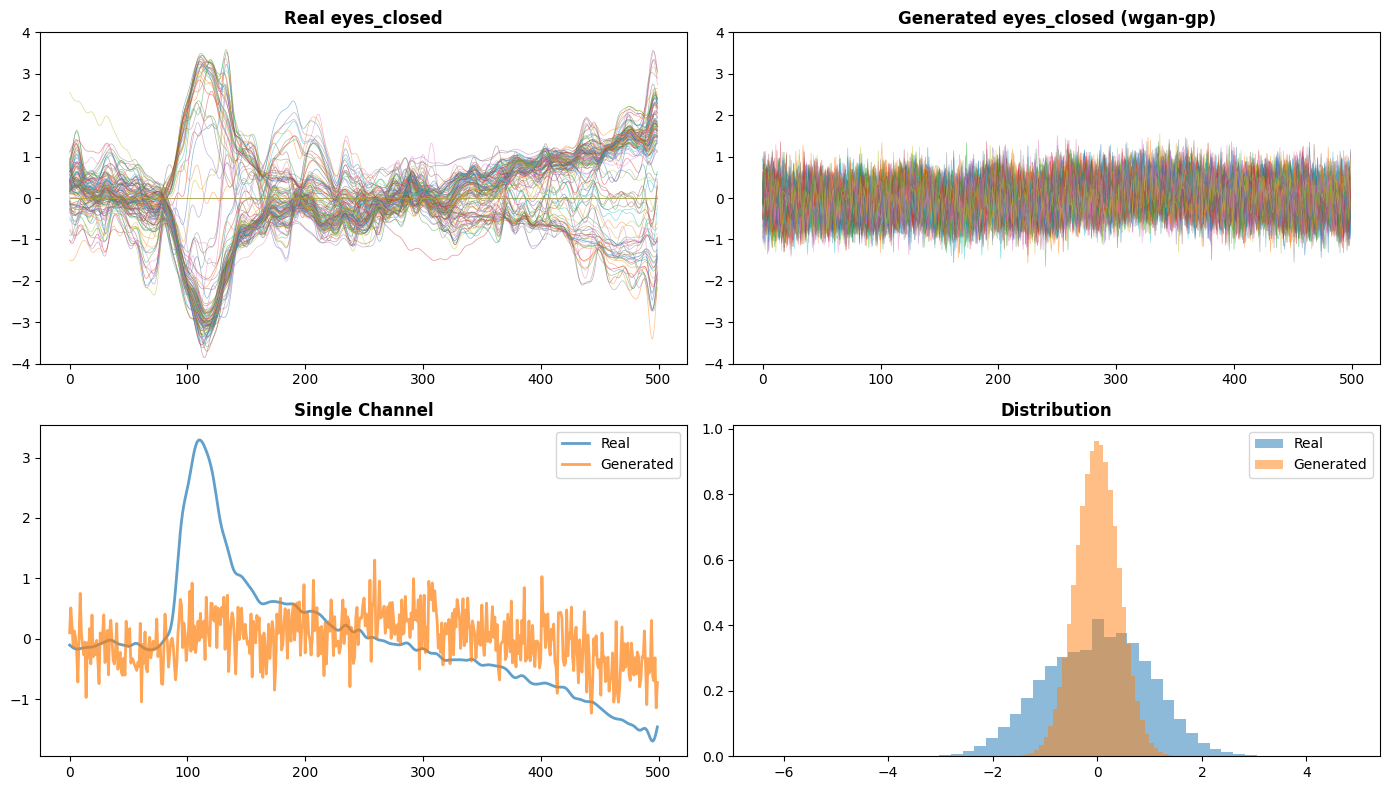

✓ Saved results for eyes_closed (wgan-gp)


In [71]:
# Extract dimensions
n_channels = segments_closed.shape[1]
n_timepoints = segments_closed.shape[2]

# TRAIN IN 3 LINES!
trainer_closed = EEGGANTrainer(segments_closed, name='eyes_closed', device=device, gan_type='wgan-gp')
trainer_closed.train(epochs=300)
synthetic_closed = trainer_closed.generate(n_samples=100)

# Evaluate
eval_closed = trainer_closed.evaluate(synthetic_closed)
print("\n" + "="*60)
print("EVALUATION RESULTS: EYES CLOSED")
print("="*60)
for key, value in eval_closed.items():
    print(f"  {key}: {value}")
print("="*60)

# Visualize
trainer_closed.plot_comparison(synthetic_closed, save_path='../../figures/eyes_closed_gan.png')

# Save
trainer_closed.save_results(synthetic_closed, eval_closed)

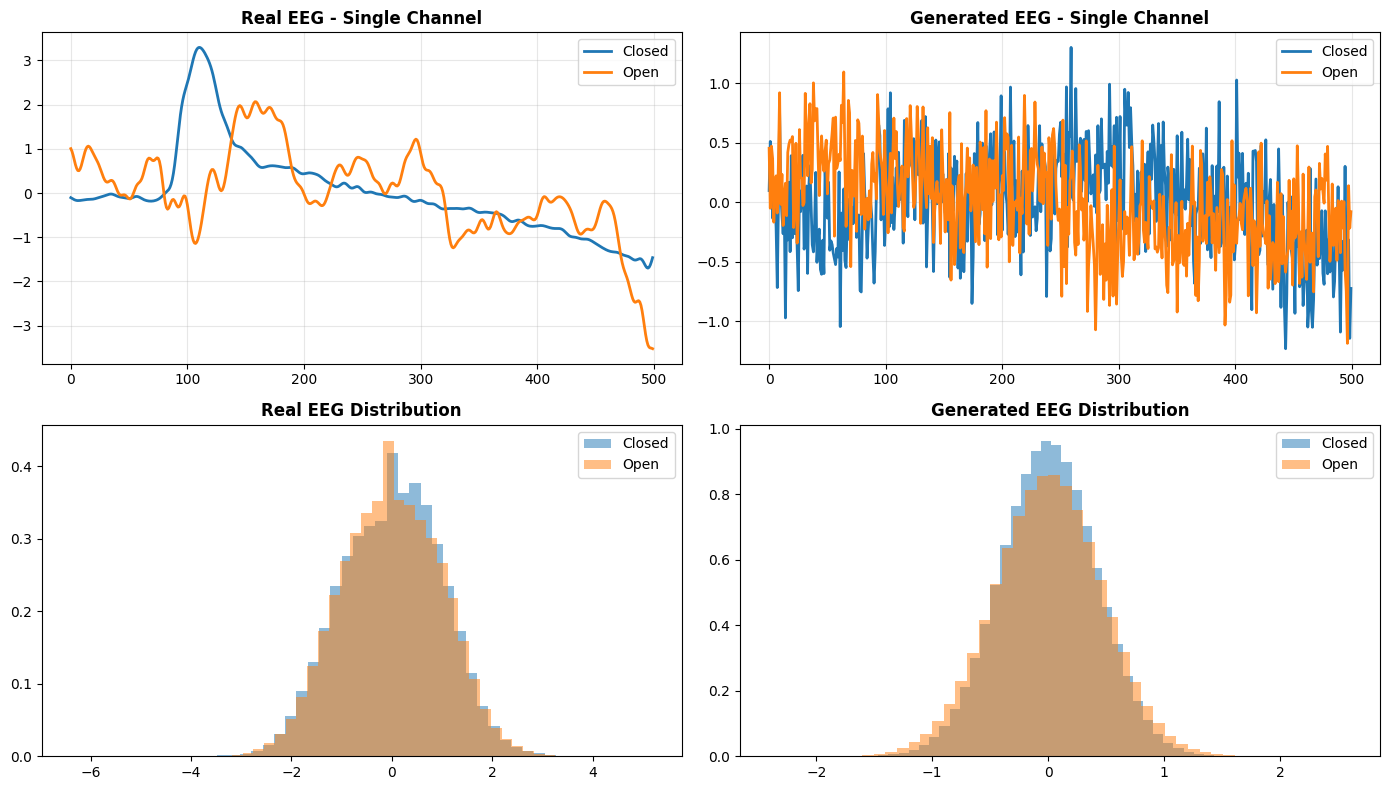


FINAL SUMMARY

Eyes Closed:
  Quality Score: 20.5/100
  Rating: Needs Improvement ⭐⭐

Eyes Open:
  Quality Score: 23.5/100
  Rating: Needs Improvement ⭐⭐

Average: 22.0/100


In [72]:
# Side-by-side comparison
fig, axes = plt.subplots(2, 2, figsize=(14, 8))

axes[0, 0].plot(segments_closed[0, 0], label='Closed', linewidth=2)
axes[0, 0].plot(segments_open[0, 0], label='Open', linewidth=2)
axes[0, 0].set_title('Real EEG - Single Channel', fontweight='bold')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

axes[0, 1].plot(synthetic_closed[0, 0], label='Closed', linewidth=2)
axes[0, 1].plot(synthetic_open[0, 0], label='Open', linewidth=2)
axes[0, 1].set_title('Generated EEG - Single Channel', fontweight='bold')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

axes[1, 0].hist(segments_closed.flatten(), bins=50, alpha=0.5, label='Closed', density=True)
axes[1, 0].hist(segments_open.flatten(), bins=50, alpha=0.5, label='Open', density=True)
axes[1, 0].set_title('Real EEG Distribution', fontweight='bold')
axes[1, 0].legend()

axes[1, 1].hist(synthetic_closed.flatten(), bins=50, alpha=0.5, label='Closed', density=True)
axes[1, 1].hist(synthetic_open.flatten(), bins=50, alpha=0.5, label='Open', density=True)
axes[1, 1].set_title('Generated EEG Distribution', fontweight='bold')
axes[1, 1].legend()

plt.tight_layout()
plt.savefig('../../figures/closed_vs_open_final.png', dpi=150)
plt.show()

# Summary report
print("\n" + "="*70)
print("FINAL SUMMARY")
print("="*70)
print(f"\nEyes Closed:")
print(f"  Quality Score: {eval_closed['overall_score']:.1f}/100")
print(f"  Rating: {eval_closed['quality']}")
print(f"\nEyes Open:")
print(f"  Quality Score: {eval_open['overall_score']:.1f}/100")
print(f"  Rating: {eval_open['quality']}")
print(f"\nAverage: {(eval_closed['overall_score'] + eval_open['overall_score'])/2:.1f}/100")
print("="*70)

✓ Saved results for eyes_closed (vanilla)


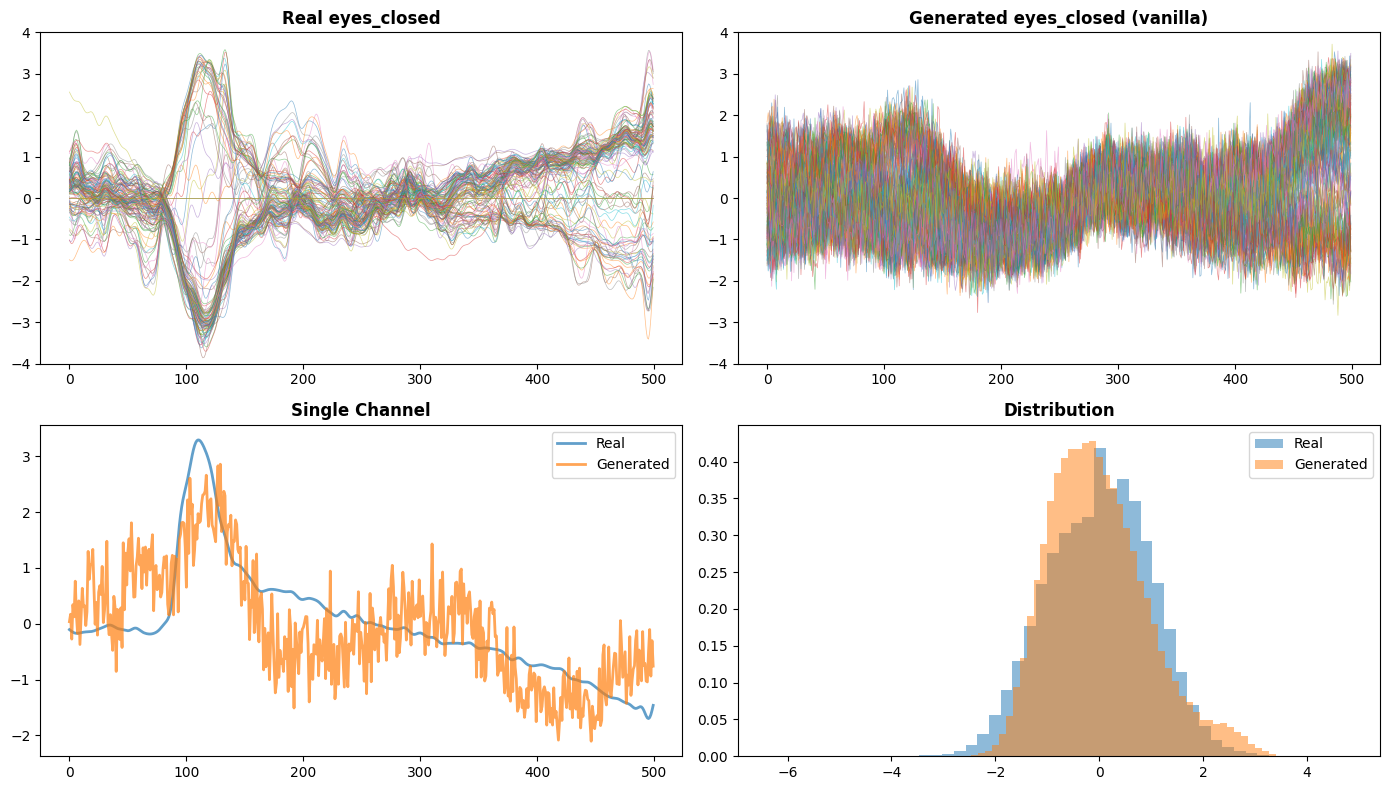

✓ Saved results for eyes_open (vanilla)


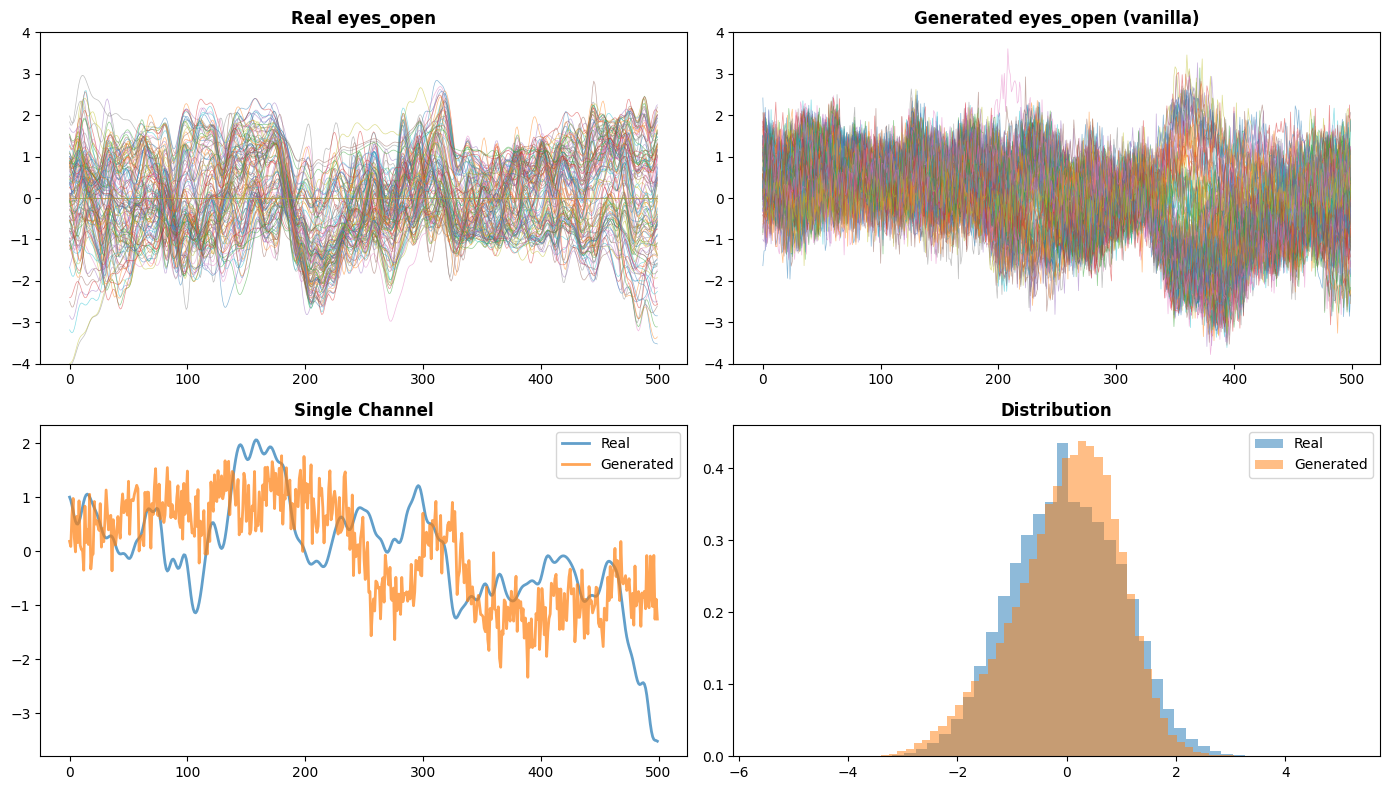

In [60]:
# save results if needed
trainer_closed.save_results(synthetic_closed, eval_closed)
trainer_closed.plot_comparison(synthetic_closed, save_path='../../figures/eyes_closed_gan.png')

trainer_open.save_results(synthetic_open, eval_open)
trainer_open.plot_comparison(synthetic_open, save_path='../../figures/eyes_open_gan.png')

# save model
trainer_closed.save_model()
trainer_open.save_model()